In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## MSEIRS Equations
Reference: 
- https://www.freecodecamp.org/news/how-to-model-an-epidemic-with-r/ 
- https://repositorium.sdum.uminho.pt/bitstream/1822/60583/1/preprint.pdf

In our MSEIRS system, we make the below assumptions:
1. The death rate and born rate are the same, which means the number of population will not change over time.
2. Both passive maternally-derived immunity and temporary immunity weakened at the same rate

In [2]:
# define the SEIR function
def MSEIRS_vaccination(time, current_state, lam, delta, start_time):
    M, S, V, E, I, R = current_state
    
    beta = 0.5
    sigma = 0.25
    gamma = 0.2
    alpha = 0
    epsilon = 0
    
    # if vaccine starts, reset beta and sigma values
    if time >= start_time:
        beta -= 0.05
        sigma -= 0.05
        gamma += 0.05
        # 6,000 people are vaccinated per day
        alpha = 0.006
        # Of all people vaccinated, 80% will be immune to the disease while 20% are not
        epsilon = 0.8
    
    N = M + S + V + E + I + R
    
    # -weakend rate * infant with immunity + new born rate * new born with immunity prob
    dM = -delta * M + lam * I * R / N
    # - contact rate * contact probabilities 
    # + new born losing passive immunity rate 
    # + new born rate * new born without immunity prob
    # - vaccine rate * vaccine efficiency * S
    dS = -(beta * S * I) / N + delta * M + lam * I * (1 - R / N) + delta * R - alpha * epsilon * S
    
    dV = alpha * epsilon * S - (beta * V * I) / N
    
    # + Vaccinated individual
    dE = (beta * S * I) / N - sigma * E + (beta * V * I) / N
    
    # infectious rate - recovery rate - death rate
    dI = sigma * E - gamma * I - lam * I
    
    # recovery rate + immunity weakened rate
    dR = gamma * I - delta * R
    
    return [dM, dS, dV, dE, dI, dR]

## Initial Parameters
beta : Transmission/Contact rate  
sigma : Infectious rate  
gamma : Recovery rate  
delta : Immunity weakened rate  
lambda : Birth/Death rate 
days : Number of days to simulate

In [3]:
# Set the parameters
lam = 0.05
delta = 0.1

# Start of intervention
start_time = 90

# Set the time points for simulation
times = np.arange(0, 366)

## S - Susceptible, E - Exposed, I - Infectious, R - Recovered
M = 0: The initial number of new born with maternal immunity is set to 0.  
S = 999999: The initial number of susceptible individuals is set to 999,999.  
V = 0: The initial number of vaccinated individuals is set to 0.  
E = 1: The initial number of exposed individuals is set to 1.  
I = 0: The initial number of infectious individuals is set to 0.  
R = 0: The initial number of recovered individuals is set to 0.  

In [4]:
# initialise the initialise state of SEIR
initial_state = [0, 999999, 0, 1, 0, 0]

## solve_ivp
To solve equation with respect to time

In [5]:
from scipy.integrate import solve_ivp

In [6]:
# Solve the SEIR model using solve_ivp
solution = solve_ivp(lambda t, 
                    y: MSEIRS_vaccination(t, y, lam, delta, start_time), 
                    [times[0], times[-1]], 
                    initial_state, t_eval=times)

## Summary of model's statistics

In [7]:
# num_scenarios = len(intervention_scenarios)
# Create an empty DataFrame with column names
df = pd.DataFrame(columns=['Compartment', 'Mean', 'Min', 'Max', '25th', '50th', '75th'])

# Access the solution arrays
M = solution.y[0]
S = solution.y[1]
V = solution.y[2]
E = solution.y[3]
I = solution.y[4]
R = solution.y[5]

# Calculate summary statistics
summary_M = np.mean(M), np.min(M), np.max(M), np.percentile(M, [25, 50, 75])
summary_S = np.mean(S), np.min(S), np.max(S), np.percentile(S, [25, 50, 75])
summary_V = np.mean(V), np.min(V), np.max(V), np.percentile(V, [25, 50, 75])
summary_E = np.mean(E), np.min(E), np.max(E), np.percentile(E, [25, 50, 75])
summary_I = np.mean(I), np.min(I), np.max(I), np.percentile(I, [25, 50, 75])
summary_R = np.mean(R), np.min(R), np.max(R), np.percentile(R, [25, 50, 75])

list_summary = [summary_M, summary_S, summary_V, summary_E, summary_I, summary_R]
summary_names = ['M', 'S', 'V', 'E', 'I', 'R']

nrow = 0
for i in range(len(list_summary)):
    # Add data row by row using DataFrame.loc
    df.loc[nrow] = [summary_names[i], 
                    list_summary[i][0], list_summary[i][1], list_summary[i][2], 
                     list_summary[i][3][0], list_summary[i][3][1], list_summary[i][3][2]]
    nrow += 1

df

,Compartment,Mean,Min,Max,25th,50th,75th
0,M,2930.143426,0.000000,5427.261633,3.118073,4161.338056,5377.691454
1,S,715056.886843,548357.416344,999999.000000,570975.832196,573306.576199,979879.528514
2,V,80522.309811,0.000000,165357.788341,5584.915913,93948.260661,108176.298012
3,E,62384.105070,0.763966,99870.507185,6131.933838,98258.834282,98409.108338
4,I,41046.106459,0.000000,66596.155590,3897.111975,65199.959198,65634.285711
5,R,98060.448392,0.000000,165243.449110,4503.391688,151779.820100,163981.650621


In [8]:
# Create a dataframe from the solution arrays
df_model = pd.DataFrame({
    'Time': times,
    "Maternal Immunity": solution.y[0],
    "Susceptible": solution.y[1],
    "Vaccinated": solution.y[2],
    "Exposed": solution.y[3],
    "Infectious": solution.y[4],
    "Recovered": solution.y[5],
})

# Extract the Infectious column
df_infections = df_model['Infectious']

# Obtain the max number of people infected
peak_infections = df_infections.max()

# Obtain the n-day when the number of people infected is max
peak_time = df_infections.idxmax()

print("The number of infections peaked on day", peak_time, "with", round(peak_infections), "people.")

# Extract the Exposed column
df_exposed = df_model['Exposed']

# Obtain the max number of people exposed
peak_exposed = df_exposed.max()

# Obtain the n-day when the number of people exposed is max
peak_time_exposed = df_exposed.idxmax()

print("The number of exposed peaked on day", peak_time_exposed, "with", round(peak_exposed), "people.")

# Extract the Susceptible column
df_sus = df_model['Susceptible']

# Obtain the max number of people exposed
peak_sus = df_sus.min()

# Obtain the n-day when the number of people exposed is max
peak_time_sus = df_sus.idxmin()

print(
    "The number of susceptible lowest on day",
    peak_time_sus,
    "with",
    round(peak_sus),
    "people.",
)

The number of infections peaked on day 199 with 66596 people.
The number of exposed peaked on day 196 with 99871 people.
The number of susceptible lowest on day 188 with 548357 people.


In [9]:
df_model

# # Extract rows based on a condition
# comp_lst = ['S', 'V', 'I', 'R']

# for i in range(len(comp_lst)):
#     df_extract = df[df['Compartment'] == comp_lst[i]]
#     print(df_extract[['Compartment', 'Min', 'Max']])

,Time,Maternal Immunity,Susceptible,Vaccinated,Exposed,Infectious,Recovered
0,0,0.000000e+00,999999.000000,0.000000,1.000000,0.000000,0.000000
1,1,5.444565e-11,999998.952554,0.000000,0.827965,0.198796,0.020685
2,2,6.381443e-10,999998.836324,0.000000,0.764550,0.329204,0.069923
3,3,2.452037e-09,999998.675975,0.000000,0.763966,0.424518,0.135541
4,4,6.080221e-09,999998.484166,0.000000,0.801190,0.503453,0.211191
...,...,...,...,...,...,...,...
361,361,5.377099e+03,573367.158530,93328.403785,98341.652260,65634.376981,163951.309147
362,362,5.376461e+03,573394.115718,93329.335735,98298.275678,65676.148548,163925.663688
363,363,5.376813e+03,573382.893607,93325.018222,98322.493641,65652.840334,163939.941604
364,364,5.377186e+03,573370.787484,93320.669929,98348.127504,65628.165638,163955.063243


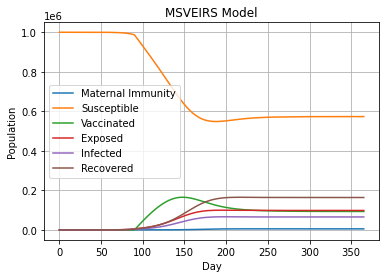

In [10]:
# Plot   
plt.plot(times, M, label='Maternal Immunity')
plt.plot(times, S, label='Susceptible')
plt.plot(times, V, label='Vaccinated')
plt.plot(times, E, label='Exposed')
plt.plot(times, I, label='Infected')
plt.plot(times, R, label='Recovered')
plt.xlabel('Day')
plt.ylabel('Population')
plt.title("MSVEIRS Model")
plt.legend()
plt.grid(True)

# # Adding horizontal and vertical lines to the peak infectious point
# point_x = peak_time  
# point_y = peak_infections

# # Horizontal line
# plt.axhline(y=point_y, color='black', linestyle='--')  
# # Vertical line
# plt.axvline(x=point_x, color='black', linestyle='--')  

# # Marking the point
# plt.scatter(point_x, point_y, color='black', marker='o') 

# # Adding text annotation for the point coordinates
# plt.text(point_x + 5, point_y + 50000, f'({point_x}, {round(point_y)})', color='black')

# # Adding horizontal and vertical lines to the peak exposed point
# point_x_e = peak_time_exposed  
# point_y_e = peak_exposed

# # Horizontal line
# plt.axhline(y=point_y_e, color='b', linestyle='--')  
# # Vertical line
# plt.axvline(x=point_x_e, color='b', linestyle='--')  

# # Marking the point
# plt.scatter(point_x_e, point_y_e, color='b', marker='o') 

# # Adding text annotation for the point coordinates
# plt.text(point_x_e - 50, point_y_e + 30000, f'({point_x_e}, {round(point_y_e)})', color='b')

# # Adding horizontal and vertical lines to the min susceptible point
# point_x_s = peak_time_sus  
# point_y_s = peak_sus

# # Horizontal line
# plt.axhline(y=point_y_s, color='y', linestyle='--')  
# # Vertical line
# plt.axvline(x=point_x_s, color='y', linestyle='--')  

# # Marking the point
# plt.scatter(point_x_s, point_y_s, color='y', marker='o') 

# # Adding text annotation for the point coordinates
# plt.text(point_x_s - 50, point_y_s + 30000, f'({point_x_s}, {round(point_y_s)})', color='y')


plt.show()

## Convert data to csv for ploting usage for all interventions

In [15]:
# df_model['Susceptible'].to_csv('Vaccinated-Susceptible.csv', index=False)
# df_model['Infectious'].to_csv('Vaccinated-Infectious.csv', index=False)

## Percentage change

In [11]:
pct_S = (summary_S[1] - 477812)/477812 * 100
pct_I = (summary_I[2] - 134301)/134301 * 100
# pct_R = (summary_R[2] - 252928)/252928 * 100

print('% change of not infected:', round(pct_S, 2))
print('% change of infected:', round(pct_I, 2))

% change of not infected: 14.76
% change of infected: -50.41
